In [19]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import optuna
from optuna.trial import TrialState

In [20]:
device = "cuda"
Epochs = 10
classes = 10

In [21]:
t = transforms.Compose([transforms.ToTensor(),
                       transforms.Lambda(lambda x : x.permute(1, 2, 0).reshape(-1))
                       ])
target_t = lambda label: F.one_hot(torch.tensor(label), num_classes=10)


train_dataset = datasets.SVHN(root="./data", split="train", transform= t, target_transform=target_t, download=True)
test_dataset = datasets.SVHN(root="./data", split="test", transform= t, target_transform=target_t, download=True)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [22]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

tensor(0)


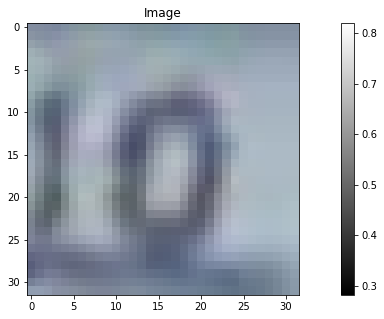

In [23]:
img = next(iter(test_loader))[0][3].reshape(32,32,3)
label = next(iter(test_loader))[1][3]
def visual(img):    
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)

    img = img.numpy()
    im = ax.imshow(img, cmap=plt.cm.gray)
    fig.colorbar(im)
    ax.set_title("Image")

visual(img)
print(torch.argmax(label))

In [24]:
#defining the model 
# We wanted to optimize these params by Optuna as well but training was taking too long 
# and we did not have a lot of time

# def define_model(trial):
#     n_layers = trial.suggest_int("n_layers", 1, 4)
    
#     layers = []
    
#     in_features = 3 * 32 * 32
#     for i in range(n_layers):
#         out_features = trial.suggest_int(f"n_units_layer{i}", 256, 1024)
#         layers.append(nn.Linear(in_features, out_features))
#         layers.append(nn.ReLU())
        
#         in_features = out_features
#     layers.append(nn.Linear(in_features, classes))
#     layers.append(nn.LogSoftmax(dim=1))
    
#     return nn.Sequential(*layers)


class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dims = 3072
        self.layer1 = nn.Linear(in_features=3072, out_features=512)
        self.layer2 = nn.Linear(in_features=512, out_features=256)
        self.layer3 = nn.Linear(in_features=256, out_features=64)
        self.layer4 = nn.Linear(in_features=64, out_features=10)
        
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.relu3 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.relu3(self.layer3(x))
        x = self.layer4(x)
        pred = F.log_softmax(x, dim=1)
        return x


In [25]:
def objective(trial):
    
#     model = define_model(trial).to(device)
    model = Network().to(device)
    
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().to(device)
    
    #training
    for epoch in range(Epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.type(torch.float32).to(device)
            
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
        #validation
        model.eval()
        total_corr = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                
                data, target = data.to(device), target.type(torch.float32).to(device)
                output = model(data)
                pred = torch.argmax(output, dim=1)
                
                gt = torch.argmax(target, dim=1)
                correct = torch.count_nonzero(pred == gt)
                total_corr += correct
        accuracy = (total_corr/len(test_dataset))
        
        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [26]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))


[I 2021-11-15 21:36:37,919] A new study created in memory with name: no-name-db921441-d557-4cb7-b58e-8604205426d6
[I 2021-11-15 21:38:40,427] Trial 0 finished with value: 0.1958358883857727 and parameters: {'optimizer': 'SGD', 'lr': 0.0003287443719295062}. Best is trial 0 with value: 0.1958358883857727.
[I 2021-11-15 21:40:42,885] Trial 1 finished with value: 0.6709050536155701 and parameters: {'optimizer': 'Adam', 'lr': 0.001022546096211708}. Best is trial 1 with value: 0.6709050536155701.
[I 2021-11-15 21:42:46,229] Trial 2 finished with value: 0.4342731833457947 and parameters: {'optimizer': 'RMSprop', 'lr': 0.0001816531898826169}. Best is trial 1 with value: 0.6709050536155701.
[I 2021-11-15 21:44:51,241] Trial 3 finished with value: 0.5474031567573547 and parameters: {'optimizer': 'Adam', 'lr': 0.006097673128479908}. Best is trial 1 with value: 0.6709050536155701.
[I 2021-11-15 21:46:54,718] Trial 4 finished with value: 0.6570374965667725 and parameters: {'optimizer': 'Adam', 'lr'

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  91
  Number of complete trials:  9


In [35]:
best_trial = study.best_trial

best_params = best_trial.params

#define a new model for these values:
best_model = Network().to(device)

criterion = nn.CrossEntropyLoss().to(device)

lr = best_params['lr']
optimizer = getattr(optim, best_params['optimizer'])(best_model.parameters(), lr=lr)


def training(Epochs):
    loss_list= []
    loss_hist  = []
    norm_list = []
    param_name = []
    for epoch in range(Epochs):
        best_model.train()
        
        cur_loss_list = []
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        for batch_idx, (data, target) in progress_bar:
            total_norm=0

            data, target = data.to(device), target.type(torch.float32).to(device)

            output = best_model(data)

            loss = criterion(output, target)
            
            cur_loss_list.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            
            for name, par in best_model.named_parameters():
                param_name.append(name)
                par_norm = par.grad.detach().data.norm(2)
                total_norm += par_norm.item() ** 2
            total_norm = total_norm ** (0.5)
            norm_list.append(total_norm)
            
            optimizer.step()
            
            if(batch_idx % 5 == 0):
                progress_bar.set_description(f"Epoch {epoch+1} Iter {batch_idx+1}: loss {loss.item():.5f}. ")
        
        loss_list = loss_list + cur_loss_list        
        loss_hist.append(np.mean(cur_loss_list))
    return loss_list, loss_hist, norm_list


loss_list, loss_hist, norm_list = training(Epochs)

Epoch 10 Iter 141: loss 0.87034. : 100%|██████| 144/144 [00:09<00:00, 15.25it/s]


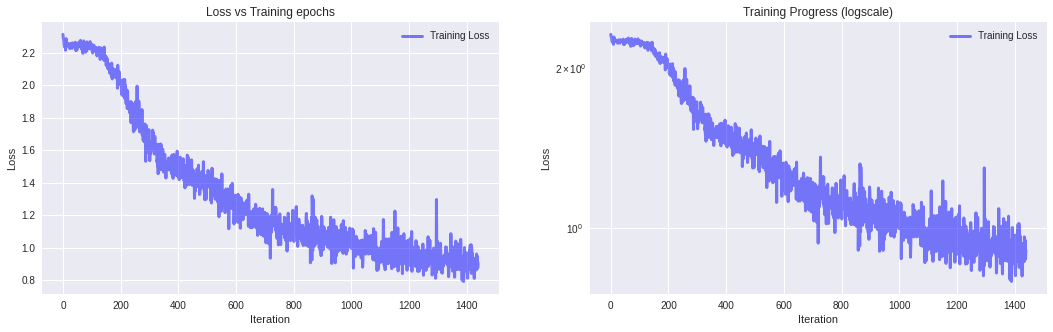

In [74]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 5)

ax[0].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss vs Training epochs")

ax[1].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Loss")
ax[1].set_yscale("log")
ax[1].set_title("Training Progress (logscale)")
plt.show()

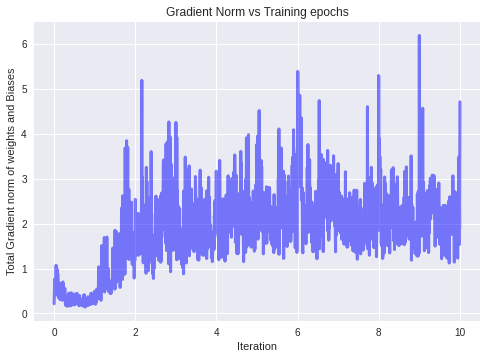

In [75]:
X = np.linspace(0, Epochs, len(norm_list))


plt.plot(X, norm_list,linewidth=3, alpha = 0.5 ,c="blue")
plt.xlabel('Iteration')
plt.ylabel('Total Gradient norm of weights and Biases')
plt.title('Gradient Norm vs Training epochs')

plt.show()


In [76]:
def testing(test_loader, net):
    best_model.eval()
    total_corr = 0
    preds = []
    labels = []
    with torch.no_grad():
        total_corr = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.type(torch.float32).to(device)
            output = best_model(data)
            
            pred = torch.argmax(output, dim=1)
            gt = torch.argmax(target, dim=1)
            
            preds.append(pred)
            labels.append(gt)

            correct = torch.count_nonzero(pred == gt)
            total_corr += correct
    accuracy = (total_corr/len(test_dataset))
    return accuracy, torch.cat(preds), torch.cat(labels)

acc_, preds, labels = testing(test_loader, best_model)

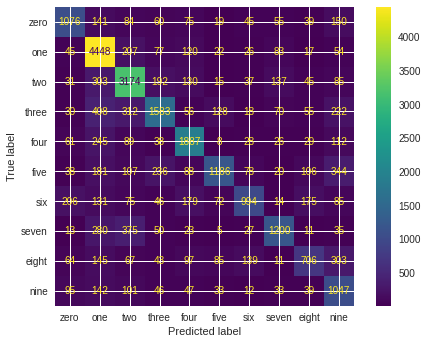

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(labels.to("cpu"), preds.to("cpu"))
CLASSES= ['zero','one','two','three','four','five','six','seven','eight','nine']
classes = np.array(CLASSES, dtype='str')
ConfusionMatrixDisplay(cf,display_labels=classes).plot()